In [1]:
import math

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import pandas as pd

In [4]:
from scipy.stats import norm

In [5]:
import datetime

In [6]:
# System parameters
ACT365FIX = 365.0
zero      = 0.005

In [7]:
# Hull-White parameters
# Global
a     = 0.1
sigma = 0.005

In [8]:
# Evaluation parameters
today                  = '2021/04/01'
application_start_date = '2021/06/01'
application_end_date   = '2021/09/01'

In [9]:
def DF(t,T):
    _t = date_to_serial(t)
    _T = date_to_serial(T)
    _tau = (_T-_t)/ACT365FIX
    
    return math.exp(-zero*_tau)

In [10]:
def FWD(s,t,T):
    _t = date_to_serial(t)
    _T = date_to_serial(T)
    _tau = (_T - _t) / ACT365FIX
    _fwd = (DF(s,t)/DF(s,T)-1.0)/_tau
    
    return _fwd

In [11]:
def date_to_serial(date):
    # date is expected as string, 'YYYY/MM/DD'
    dt = datetime.datetime.strptime(date, '%Y/%m/%d')- datetime.datetime(1899, 12, 31)
    serial = dt.days + 1
    return serial

In [12]:
def B(s,t):
    s = date_to_serial(s)
    t = date_to_serial(t)
    ret = (1-math.exp(-a*(t-s)))/a
    return ret

In [13]:
def M(s,t,T):
    s = date_to_serial(s)
    t = date_to_serial(t)
    T = date_to_serial(T)
    tmp = (sigma**2)/(a**2)*(1-math.exp(-a*(t-s)))\
        -0.5*(sigma**2)/(a**2)*(math.exp(-a*(T-t))-math.exp(-a*(T-s+t-s)))
    return tmp

In [14]:
def V(s,t):
    s = date_to_serial(s)
    t = date_to_serial(t)
    tmp = 0.5*((sigma**2)/(a**3))*(2*a*(t-s)-3+4*math.exp(-a*(t-s))-math.exp(-2*a*(t-s)))
    return tmp

In [15]:
def ND_F(x):
    return norm.cdf(x, loc=0, scale=1)

In [16]:
def _T(a, today, application_start_date, application_end_date):
    int_term = application_end_date-application_start_date
    pre_term = application_start_date-today
    
    tmp = 1/(2*a)*(((1-math.exp(-a*int_term))/a)**2) * (1-math.exp(-2*a*pre_term)) \
        + 1/(a**2)*(int_term+2/a*math.exp(-a*int_term)-1/(2*a)*math.exp(-2*a*int_term)-3/(2*a))
    return tmp

In [17]:
def caplet_compound(today, rate, strike, application_start_date, application_end_date):
    today                  = date_to_serial(today)
    application_start_date = date_to_serial(application_start_date)
    application_end_date   = date_to_serial(application_end_date)
    
    tau = (application_end_date - application_start_date) / ACT365FIX
    d_1 = (math.log((1.0+tau*rate)/(1.0+tau*strike))+(sigma**2)*0.5*_T(a, today, application_start_date, application_end_date))/(sigma*math.sqrt(_T(a, today, application_start_date, application_end_date)))
    d_2 = d_1 - sigma*math.sqrt(_T(a, today, application_start_date, application_end_date))
    
    return ((1.0+tau*rate)*ND_F(d_1)-(1.0+tau*strike)*ND_F(d_2))

In [18]:
Underlying = FWD(today, application_start_date, application_end_date)

In [19]:
print('Underlying = ',str(Underlying))

Underlying =  0.005003152008923872


In [20]:
strike_factor = 0.5
strike = Underlying*strike_factor

In [21]:
caplet_compound(today, Underlying, strike, application_start_date, application_end_date)

0.17958360488604413

In [22]:
import numpy as np

In [23]:
mu = -B(application_start_date, application_end_date) * M(today, application_start_date, application_end_date) \
   -  V(application_start_date, application_end_date) + math.log(DF(today, application_start_date)/DF(today, application_end_date))\
   + 0.5*(V(today, application_end_date)-V(today, application_start_date)) 

In [24]:
variance = (B(application_start_date, application_end_date)**2)*(sigma**2)/(2*a)*(1-math.exp(-2*a*(date_to_serial(application_start_date)-date_to_serial(today))))+\
         + (sigma**2)/(a**2)*(date_to_serial(application_end_date) - date_to_serial(application_start_date) + (2/a)*math.exp(-a*(date_to_serial(application_end_date) - date_to_serial(application_start_date)))-1/(2*a)*math.exp(-2*a*(date_to_serial(application_end_date) - date_to_serial(application_start_date)))-3/(2*a))

In [25]:
mu

-0.10124095758592584

In [26]:
math.sqrt(variance)

0.45277197695645544

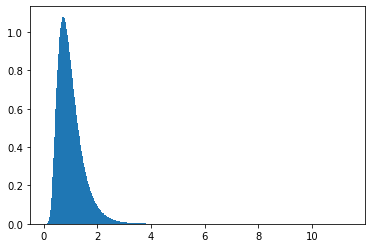

In [27]:
rv = np.random.lognormal(mu, math.sqrt(variance), 100000000)
count, bins, ignored = plt.hist(rv, 1000, density=True, align='mid')
#np.savetxt('comp_out.csv',rv,delimiter=',')
plt.show()

In [28]:
tau = (date_to_serial(application_end_date) - date_to_serial(application_start_date))/ACT365FIX
adj_strike = 1 + tau*strike 

In [29]:
aylst = rv

In [30]:
payoff = aylst - adj_strike

In [31]:
payoff[payoff < 0] = 0

In [32]:
calplet_detail = pd.DataFrame(np.array([aylst, aylst - adj_strike, payoff]).T, columns=['original_value','original_value - adjstrike','payoff'])

In [33]:
calplet_detail['payoff'].mean()

0.17958964944389957

In [34]:
calplet_detail

,original_value,original_value - adjstrike,payoff
0,0.638844,-0.361786,0.000000
1,0.737932,-0.262699,0.000000
2,1.529656,0.529026,0.529026
3,2.070250,1.069619,1.069619
4,1.182178,0.181548,0.181548
...,...,...,...
99999995,0.264248,-0.736383,0.000000
99999996,0.682087,-0.318544,0.000000
99999997,1.499534,0.498904,0.498904
99999998,0.572110,-0.428520,0.000000
